# Approximating average fluorescence over an ROI with a Gaussian

We'd like to know how well the Gaussian noise approximation holds up as the number of pixels approaches 0.
We assume a Poisson distribution of expected photon count $\lambda$ per pixel, with a Gaussian-distributed noise on top corresponding to electronic measurement noise.

$$ x \sim \text{Pois}(\lambda) $$
$$ y \sim \mathcal{N}(x, \sigma)$$

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.stats import norm, poisson
plt.style.use('seaborn-v0_8-paper')

int gauss 0.9981029012016058
int poisson 0.49945164051607066
int p_y 0.9320689063039119


[Text(0.5, 1.0, 'p(y)'), Text(0.5, 0, 'y')]

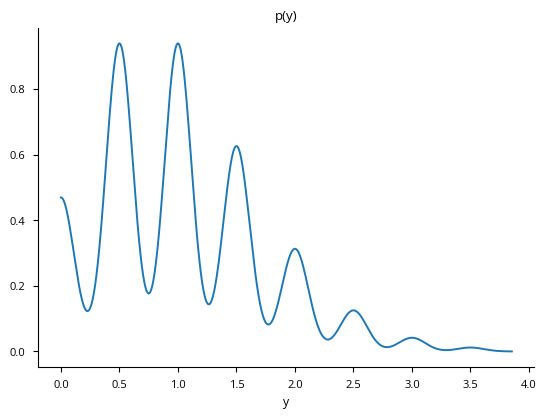

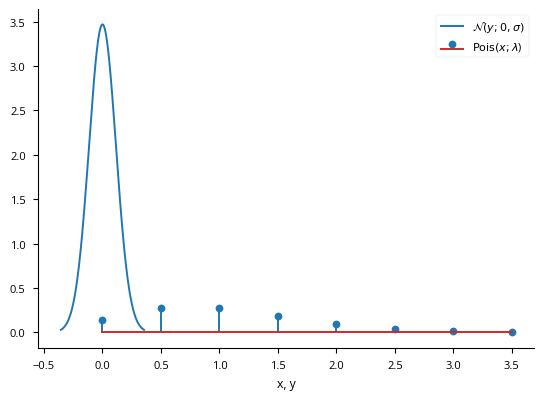

In [2]:
def poisson_vec(x, lam):
    # return np.exp(-lam) * lam**x / factorial(x)
    return scipy.stats.poisson.pmf(x, lam)

def p(n=1, lam=1, sigma=0.23, debug=False):
    sigma /= n
    gauss_range = np.linspace(
        norm.ppf(.001, loc=0, scale=sigma),
        norm.ppf(.999, loc=0, scale=sigma),
        200
    )
    dy = np.diff(gauss_range)[0]
    gauss_noise = norm.pdf(gauss_range, loc=0, scale=sigma)

    pois_range = np.arange(
        poisson.ppf(.001, lam * n),
        poisson.ppf(.999, lam * n),
        1
    )  # integer steps
    pois_noise = poisson_vec(pois_range, lam * n)
    # scale back to average per pixel instead of sum over pixels
    pois_range /= n

    y = np.arange(0, pois_range[-1] + gauss_range[-1], dy)
    p_y = np.zeros_like(y)

    for x, p_x in zip(pois_range, pois_noise):
        p_y += norm.pdf(y, loc=x, scale=sigma) * p_x

    # p_y = np.convolve(pois_noise, gauss_noise, mode='same') * dy

    if debug:
        fig, ax = plt.subplots()
        ax.stem(pois_range, pois_noise, label='$\mathrm{Pois}(x; \lambda$)')
        ax.plot(gauss_range, gauss_noise, label='$\mathcal{N}(y; 0, \sigma)$')
        ax.set(xlabel='x, y')
        ax.legend()
        print('int gauss', np.sum(gauss_noise) * dy)
        print('int poisson', np.sum(pois_noise) * np.diff(pois_range)[0])
        print('int p_y', np.sum(p_y) * dy)
        
    return y, p_y

fig, ax = plt.subplots()
ax.plot(*p(n=2, debug=True))
ax.set(title='p(y)', xlabel='y')

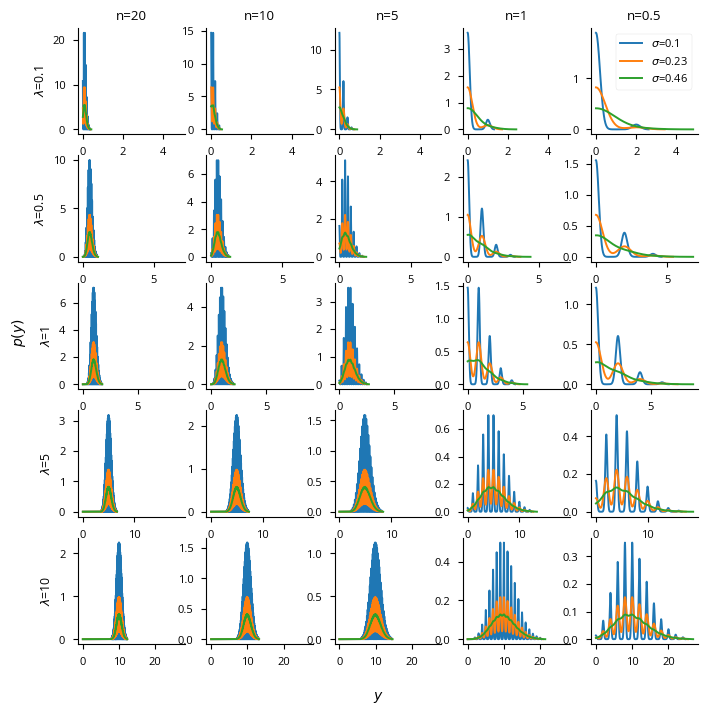

In [3]:
lams = [.1, .5, 1, 5, 10]
nn = [20, 10, 5, 1, .5]
sigmas = [0.1, 0.23, 0.46]
fig, axs = plt.subplots(len(lams), len(nn), figsize=(8, 1.6*len(lams)), sharey=False, sharex=False)
for lam, ax_row in zip(lams, axs):
    for n, ax in zip(nn, ax_row):
        for sigma in sigmas:
            ax.plot(*p(n=n, lam=lam, sigma=sigma), label=f'$\sigma$={sigma}', rasterized=False)
    xlim = ax.get_xlim()
    # make xlims the same for each row
    for ax in ax_row:
        ax.set(xlim=xlim)

for n, ax in zip(nn, axs[0]):
    ax.set_title(f'n={n}')
for lam, ax in zip(lams, axs[:, 0]):
    ax.set(ylabel=f'$\lambda$={lam}')
axs[0, -1].legend()
fig.text(0.5, 0.04, '$y$', ha='center')
fig.text(0.04, 0.5, '$p(y)$', va='center', rotation='vertical')
fig.savefig('img/fig/imaging-noise.pdf')

The conclusions I draw from this is:
- When $\sigma$ is small, the distribution is spiky. We can abstract over this by assuming a smooth Gaussian.
- When expected photon counts $\lambda > 1$, a Gaussian does okay.
- When $\lambda \leq 1$, corresponding to a neuron with a low signal (e.g., low calcium levels), the Poisson shape is more prominent.
  - We assume that neurons with high noise levels (few visible pixels) would be thrown out by an SNR threshold, so the failure to capture the skewed Poisson shape shouldn't be a problem.
  This might correspond to throwing out neurons with a small ROI in a real experiment.
- The most relevant model mismatch appears to be when $\lambda$ is small and the number of pixels $N$ is still large, which would come up often in real experiments.
  This is a limitation to keep in mind.


To capture the dependence of variance on the number of pixels, we can use the fact that both the Gaussian and Poisson distributions have standard deviation $\sigma$ that vary with $1/\sqrt{N}$.
Let's see what this looks like combined with the drop-off in pixel number with distance from the plane of imaging.
Since $\sigma_\text{noise} \propto 1/\sqrt{N}$, 

$$ \text{SNR} \propto \frac{1}{\sigma_\text{noise}} \propto \sqrt{N} $$

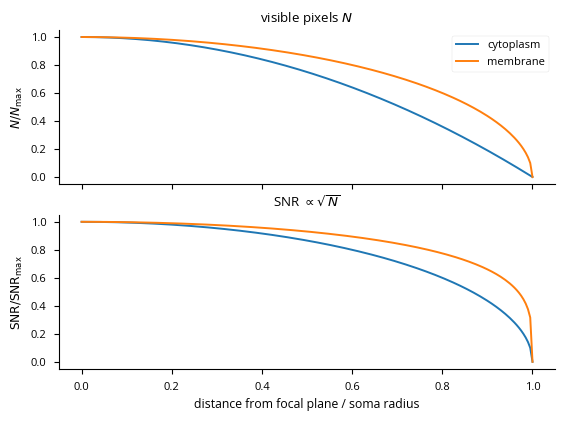

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
d = np.linspace(0, 1, 200)
soma_radius = 1
r_soma_visible = np.sqrt(soma_radius**2 - d**2)
ax1.plot(d, (r_soma_visible / soma_radius) ** 2, label="cytoplasm")
ax1.plot(d, (r_soma_visible / soma_radius), label="membrane")
ax1.set(title="visible pixels $N$", ylabel="$N / N_\mathrm{max}$")
ax1.legend()

ax2.plot(d, (r_soma_visible / soma_radius), label="cytoplasm")
ax2.plot(d, (r_soma_visible / soma_radius) ** 0.5, label="membrane")
ax2.set(
    title="SNR $\propto \sqrt{N}$",
    xlabel="distance from focal plane / soma radius",
    ylabel="$\mathrm{SNR} / \mathrm{SNR}_\mathrm{max}$",
)
fig.savefig("img/fig/imaging-snr.pdf")